# Tracking Error Portfolio - 10 Activos Seleccionados

## Versión Simplificada y Educativa

Optimización de cartera relativa al benchmark con solo los 10 mejores activos, con explicaciones paso a paso.

In [1]:
import sys
sys.path.insert(0, '../codigo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tracking_error_portfolio import *
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('[OK] Librerias importadas')

[OK] Librerias importadas


## PASO 1: ¿Qué es Tracking Error?

**Definición:** Medir cuánto se desvía una cartera de su benchmark (índice).

**Fórmula simple:**
```
Tracking Error = sqrt(Varianza(Retorno_Cartera - Retorno_Benchmark))

Objetivo: Crear una cartera que supere el benchmark minimizando riesgo relativo
```

**En la práctica:**
- Si Benchmark sube 10%, queremos que nuestra cartera suba 11-12%
- Con el menor riesgo posible de desviación

## PASO 2: Cargar Datos

In [2]:
datos_retornos = pd.read_excel('../../data/prod_long_sharpe_u60_20260125_v1_train_dataset.csv', sheet_name='Sheet1')
datos_retornos.columns = [f'Activo_{i}' for i in range(1, 61)]

indice_retornos = pd.read_excel('../../data/prod_long_sharpe_u60_20260125_v1_train_dataset.csv', sheet_name='Indice')
benchmark_retornos = indice_retornos.iloc[:, 0]

print(f'Total activos disponibles: {datos_retornos.shape[1]}')
print(f'Total períodos: {datos_retornos.shape[0]}')
print(f'Benchmark shape: {benchmark_retornos.shape}')

Total activos disponibles: 60
Total períodos: 1758
Benchmark shape: (1758,)


## PASO 3: Seleccionar 10 Mejores Activos

**Criterio:** Los 10 activos con mayor Sharpe Ratio (mejor retorno por riesgo)

In [3]:
retorno_anual = datos_retornos.mean() * 252
volatilidad_anual = datos_retornos.std() * np.sqrt(252)
sharpe = retorno_anual / volatilidad_anual

top_10_activos = sharpe.nlargest(10).index.tolist()
print(f'[OK] Seleccionados 10 activos con mejor Sharpe Ratio:')
print()
for i, activo in enumerate(top_10_activos, 1):
    print(f'{i:2d}. {activo}: Sharpe={sharpe[activo]:.4f}, Retorno={retorno_anual[activo]*100:.2f}%, Vol={volatilidad_anual[activo]*100:.2f}%')

datos_10_activos = datos_retornos[top_10_activos]
print(f'\nDataset reducido: {datos_10_activos.shape}')

[OK] Seleccionados 10 activos con mejor Sharpe Ratio:

 1. Activo_51: Sharpe=1.4116, Retorno=27.34%, Vol=19.37%
 2. Activo_56: Sharpe=1.3227, Retorno=24.21%, Vol=18.30%
 3. Activo_47: Sharpe=1.1851, Retorno=20.70%, Vol=17.47%
 4. Activo_41: Sharpe=1.0964, Retorno=20.98%, Vol=19.14%
 5. Activo_43: Sharpe=0.8913, Retorno=25.09%, Vol=28.15%
 6. Activo_50: Sharpe=0.8659, Retorno=18.81%, Vol=21.72%
 7. Activo_22: Sharpe=0.8097, Retorno=30.32%, Vol=37.44%
 8. Activo_16: Sharpe=0.7183, Retorno=19.13%, Vol=26.64%
 9. Activo_48: Sharpe=0.6522, Retorno=25.06%, Vol=38.43%
10. Activo_18: Sharpe=0.6504, Retorno=15.52%, Vol=23.87%

Dataset reducido: (1758, 10)


## PASO 4: Calcular Estadísticas

**¿Qué calculamos?**
- Media de retornos de cada activo
- Matriz de covarianza (cómo se mueven juntos)
- Relación con el benchmark

In [4]:
stats = calcular_estadisticas(datos_10_activos, benchmark_retornos)

print('[ESTADISTICAS DE 10 ACTIVOS]')
print()
print(f'Retorno promedio activos: {stats["mu"].mean()*252*100:.2f}%')
print(f'Retorno benchmark: {stats["mu_benchmark"]*252*100:.2f}%')
print()
print(f'Volatilidad promedio activos: {np.sqrt(np.diag(stats["cov_matrix"]).mean())*np.sqrt(252)*100:.2f}%')
print(f'Volatilidad benchmark: {np.sqrt(stats["var_benchmark"])*np.sqrt(252)*100:.2f}%')

[ESTADISTICAS DE 10 ACTIVOS]

Retorno promedio activos: 22.72%
Retorno benchmark: 0.64%

Volatilidad promedio activos: 26.09%
Volatilidad benchmark: 18.18%


## PASO 5: Optimización - La Magia

**¿Qué hace el optimizador?**

1. Prueba diferentes combinaciones de pesos
2. Para cada combinación, calcula:
   - Retorno esperado de la cartera
   - Tracking error (riesgo relativo)
   - Sharpe relativo = Excess Return / Tracking Error
3. Elige la combinación que MAXIMIZA Sharpe relativo

**En otras palabras:** Encuentra qué activos y cuántos pesos asignar a cada uno para ganarle al benchmark con el menor riesgo posible.

In [5]:
resultado = optimizar_tracking_error(datos_10_activos, benchmark_retornos, verbose=True)

pesos_optimos = resultado['pesos']
print()
print('[RESULTADOS DE OPTIMIZACION]')
print(f'Retorno cartera vs benchmark: {resultado["excess_return"]*100:.2f}% (outperformance)')
print(f'Tracking error (riesgo relativo): {resultado["tracking_error"]*100:.2f}%')
print(f'Sharpe relativo: {resultado["sharpe_relativo"]:.4f}')

[OK] Optimizacion completada
Retorno esperado portafolio: 0.2589 (25.89%)
Tracking error anualizado: 0.1538 (15.38%)
Sharpe relativo: 1.6421
Excess return: 0.2525 (25.25%)
Retorno benchmark: 0.0064 (0.64%)

[RESULTADOS DE OPTIMIZACION]
Retorno cartera vs benchmark: 25.25% (outperformance)
Tracking error (riesgo relativo): 15.38%
Sharpe relativo: 1.6421


## PASO 6: Pesos Óptimos

**¿Cuánto invertir en cada activo?**

El optimizador dice: "Mete 25% aquí, 15% allá, 0% en esto otro..."

In [6]:
resumen_10 = pd.DataFrame({
    'Activo': top_10_activos,
    'Peso': pesos_optimos,
    'Peso_Porcentaje': pesos_optimos * 100
})

resumen_10 = resumen_10[resumen_10['Peso'] > 0.001].sort_values('Peso', ascending=False)

print('[DISTRIBUCION DE PESOS - 10 ACTIVOS]')
print()
print(resumen_10.to_string(index=False))
print()
print(f'Suma total: {resumen_10["Peso"].sum():.4f} (debe ser 1.0)')
print(f'Activos con peso > 0.1%: {len(resumen_10)}')

[DISTRIBUCION DE PESOS - 10 ACTIVOS]

   Activo     Peso  Peso_Porcentaje
Activo_51 0.336784        33.678367
Activo_48 0.226804        22.680418
Activo_22 0.124087        12.408705
Activo_56 0.117319        11.731905
Activo_41 0.086247         8.624736
Activo_43 0.086178         8.617776
Activo_50 0.022581         2.258092

Suma total: 1.0000 (debe ser 1.0)
Activos con peso > 0.1%: 7


## PASO 7: Comparar vs Benchmark

**¿Qué tal nos fue?**

Comparamos nuestra cartera optimizada contra el benchmark en el tiempo.

In [7]:
performance = calcular_performance_portafolio(datos_10_activos, benchmark_retornos, pesos_optimos)

valor_cartera = performance['valor_portafolio']
valor_benchmark = performance['valor_benchmark']

retorno_total_cartera = (valor_cartera[-1] - 1) * 100
retorno_total_benchmark = (valor_benchmark[-1] - 1) * 100
outperformance = ((valor_cartera[-1] / valor_benchmark[-1]) - 1) * 100

print('[PERFORMANCE ACUMULADA]')
print()
print(f'Cartera (10 activos):    {retorno_total_cartera:>7.2f}%')
print(f'Benchmark:               {retorno_total_benchmark:>7.2f}%')
print(f'Outperformance:          {outperformance:>7.2f}%')
print()
print(f'Volatilidad cartera:     {np.std(performance["retornos_portafolio"])*np.sqrt(252)*100:>7.2f}%')
print(f'Volatilidad benchmark:   {np.std(performance["retornos_benchmark"])*np.sqrt(252)*100:>7.2f}%')

[PERFORMANCE ACUMULADA]

Cartera (10 activos):     454.64%
Benchmark:                 -6.79%
Outperformance:           495.03%

Volatilidad cartera:       16.27%
Volatilidad benchmark:     18.18%


## PASO 8: Visualizar Resultados

**Ver es creer:** 4 gráficos para entender la estrategia

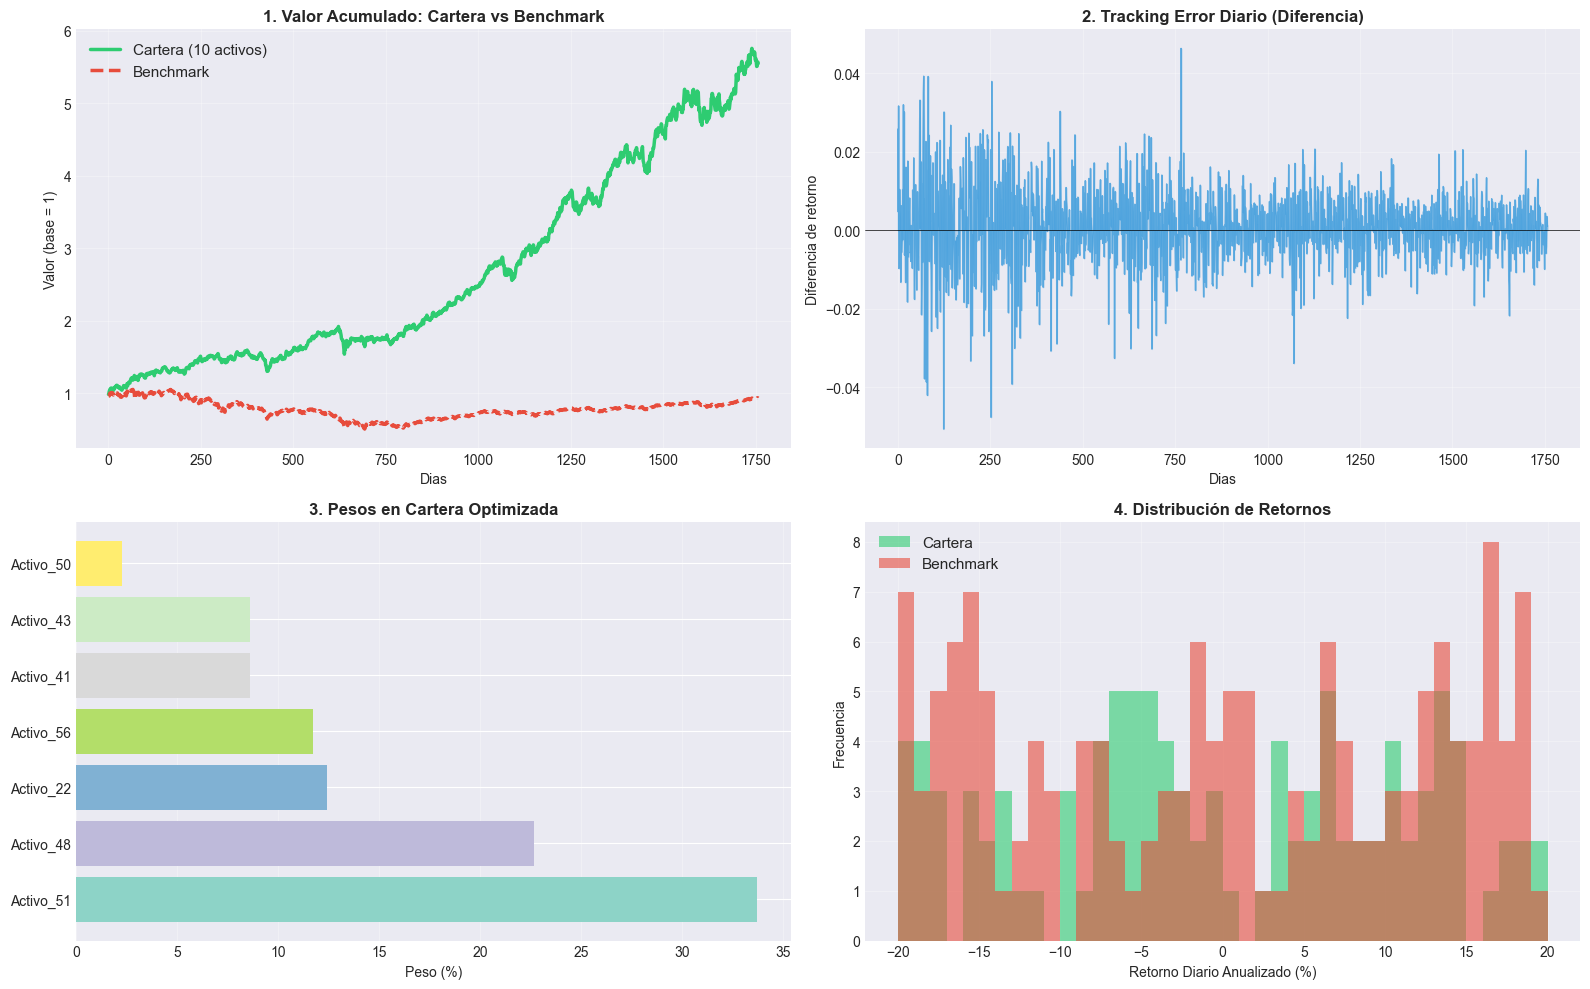

[OK] Gráficos guardados: tracking_error_10_activos.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(valor_cartera, label='Cartera (10 activos)', linewidth=2.5, color='#2ecc71')
axes[0, 0].plot(valor_benchmark, label='Benchmark', linewidth=2.5, color='#e74c3c', linestyle='--')
axes[0, 0].set_title('1. Valor Acumulado: Cartera vs Benchmark', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Dias')
axes[0, 0].set_ylabel('Valor (base = 1)')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

tracking_error_dinamico = performance['tracking_error_dinamico']
axes[0, 1].plot(tracking_error_dinamico, linewidth=1, color='#3498db', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].fill_between(range(len(tracking_error_dinamico)), tracking_error_dinamico, 0, alpha=0.3, color='#3498db')
axes[0, 1].set_title('2. Tracking Error Diario (Diferencia)', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Dias')
axes[0, 1].set_ylabel('Diferencia de retorno')
axes[0, 1].grid(alpha=0.3)

colors = plt.cm.Set3(np.linspace(0, 1, len(resumen_10)))
axes[1, 0].barh(range(len(resumen_10)), resumen_10['Peso_Porcentaje'], color=colors)
axes[1, 0].set_yticks(range(len(resumen_10)))
axes[1, 0].set_yticklabels(resumen_10['Activo'])
axes[1, 0].set_xlabel('Peso (%)')
axes[1, 0].set_title('3. Pesos en Cartera Optimizada', fontweight='bold', fontsize=12)
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].hist(performance['retornos_portafolio']*252*100, bins=40, alpha=0.6, label='Cartera', color='#2ecc71', range=(-20, 20))
axes[1, 1].hist(performance['retornos_benchmark']*252*100, bins=40, alpha=0.6, label='Benchmark', color='#e74c3c', range=(-20, 20))
axes[1, 1].set_xlabel('Retorno Diario Anualizado (%)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('4. Distribución de Retornos', fontweight='bold', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tracking_error_10_activos.png', dpi=300, bbox_inches='tight')
plt.show()

print('[OK] Gráficos guardados: tracking_error_10_activos.png')

## PASO 9: Exportar Pesos

**Guardar la estrategia para usar después**

In [9]:
pesos_redondeados = [round(p, 3) for p in pesos_optimos]

df_export = pd.DataFrame({
    'Activo': [f'Activo_{i}' for i in range(1, 61)],
    'Peso': pesos_redondeados,
    'Peso_Porcentaje': [round(p*100, 1) for p in pesos_redondeados]
})

df_export.to_csv('../vector_pesos_tracking_error_10activos.csv', index=False)

print('[OK] Pesos exportados: vector_pesos_tracking_error_10activos.csv')
print()
print('RESUMEN FINAL:')
print(f'  - Activos seleccionados: 10')
print(f'  - Activos con peso > 0%: {(df_export["Peso"] > 0).sum()}')
print(f'  - Retorno esperado: {resultado["retorno_esperado"]*100:.2f}%')
print(f'  - Tracking error: {resultado["tracking_error"]*100:.2f}%')
print(f'  - Sharpe relativo: {resultado["sharpe_relativo"]:.4f}')
print(f'  - Outperformance vs benchmark: {resultado["excess_return"]*100:.2f}%')

ValueError: All arrays must be of the same length